In [84]:
# Proyecto de GLM - Modelo de Frecuencia
# Realizado por: 52960729- Johanna Patricia Barrantes Bohórquez
# Fecha: 31 de marzo de 2025
# Maestria Analisis y Gerencia de Datos


import sys
import os
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import math
import patsy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.count_model import ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP
warnings.filterwarnings("ignore")

In [85]:
sys.path.append('/content/src/')
from Funciones_JPBB import *

# Configuración de directorios y columnas
directory_path = '/content/'
file_pattern = 'part-*.parquet'
# Reducimos las variables en Factores, eliminando las no relevantes o redundantes
Factores = [
"Etiq_AGUAACAGBC", "Pluviometria_anual", "Flood_AVG", "FLRF_RISK", "PREC_ERA5_10Y", "zona_inundable", "cursos_de_agua",
            "dias_minima_bajo_cero_invier", "DIAS_PREC_SUP_10MM", "Altitud", "Slope_AVG", "DIST_COAST", "EU_IMP_IMD_100m",
            "zonas_hume", "antigedif", "AnyoCons_edif", "p_viviendas_mal_estado", "SUPERFICIE", "renta_bruta_media",
            "p_upers", "mediaEdad", "PROPIETARIO"
]
Variables_clave = ["stro_Corr_AGUAACAGBC", "exp_corr_ACAGBC", "CUPD_CAP_Corr_aguaacagbc"]
columns = Factores + Variables_clave

# 1. Cargar datos (sin filtrar ceros)
df = load_and_process_data(directory_path, file_pattern, columns)

# Verificar las columnas disponibles en el DataFrame
print("\nColumnas disponibles en el DataFrame después de cargar los datos:")
print(df.columns.tolist())


📂 Cargando archivo: /content/part-00000-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
📂 Cargando archivo: /content/part-00001-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
📂 Cargando archivo: /content/part-00002-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
📂 Cargando archivo: /content/part-00003-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
📂 Cargando archivo: /content/part-00004-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
✅ Datos cargados y procesados correctamente. Total de filas: 151447

Columnas disponibles en el DataFrame después de cargar los datos:
['Etiq_AGUAACAGBC', 'Pluviometria_anual', 'Flood_AVG', 'FLRF_RISK', 'PREC_ERA5_10Y', 'zona_inundable', 'cursos_de_agua', 'dias_minima_bajo_cero_invier', 'DIAS_PREC_SUP_10MM', 'Altitud', 'Slope_AVG', 'DIST_COAST', 'EU_IMP_IMD_100m', 'zonas_hume', 'antigedif', 'AnyoCons_edif', 'p_viviendas_mal_estado', 'SUPERFICIE', 'renta_bruta_media', 'p_upers', 'mediaEdad', 'PROPIETARIO', 'str

In [86]:
df.head(-1)

,Etiq_AGUAACAGBC,Pluviometria_anual,Flood_AVG,FLRF_RISK,PREC_ERA5_10Y,zona_inundable,cursos_de_agua,dias_minima_bajo_cero_invier,DIAS_PREC_SUP_10MM,Altitud,...,SUPERFICIE,renta_bruta_media,p_upers,mediaEdad,PROPIETARIO,stro_Corr_AGUAACAGBC,exp_corr_ACAGBC,CUPD_CAP_Corr_aguaacagbc,frecuencia,severidad
0,Valores coherentes,336.0,0.329878,0.0,48.008861,1.0,NaN,5.25,12.0,552.0,...,3520.0,8325.861589,0.1756,41.971583,S,1.0,0.836066,766.60,1.196078,766.60
1,Valores coherentes,336.0,0.329878,0.0,48.008861,1.0,NaN,5.25,12.0,552.0,...,3520.0,8246.130788,0.1756,41.971583,S,1.0,0.273973,553.53,3.650000,553.53
2,Valores coherentes,336.0,0.329878,0.0,48.008861,1.0,NaN,5.25,12.0,552.0,...,4550.0,8246.130788,0.1756,41.971583,S,1.0,0.252055,841.33,3.967391,841.33
3,Valores coherentes,336.0,0.329878,0.0,48.008861,1.0,NaN,5.25,12.0,552.0,...,400.0,8246.130788,0.1756,41.971583,S,1.0,0.915068,195.51,1.092814,195.51
4,Valores coherentes,336.0,0.329878,0.0,48.008861,1.0,NaN,5.25,12.0,552.0,...,1800.0,8263.746672,0.1756,41.971583,S,1.0,0.049315,351.09,20.277778,351.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151441,Valores coherentes,NaN,0.000000,0.0,50.212594,1.0,NaN,NaN,15.0,NaN,...,929.0,11199.181843,0.1837,34.741143,S,1.0,0.586301,791.71,1.705607,791.71
151442,Valores coherentes,NaN,0.000000,0.0,50.212594,1.0,NaN,NaN,15.0,NaN,...,929.0,11199.181843,0.1837,34.741143,S,1.0,0.336986,78.88,2.967480,78.88
151443,Valores coherentes,NaN,0.000000,0.0,50.212594,1.0,NaN,NaN,15.0,NaN,...,538.0,11342.639721,0.1837,34.741143,S,1.0,0.589041,188.99,1.697674,188.99
151444,Valores coherentes,NaN,0.000000,0.0,50.212594,1.0,NaN,NaN,15.0,NaN,...,328.0,11342.639721,0.1837,34.741143,S,1.0,0.504110,631.33,1.983696,631.33


In [87]:
generar_resumen_exploratorio(df, Factores)

,Variable,Tipo,Nulos,Cantidad,Promedio,Moda,Min,Max,Outliers (IQR),% Outliers,#Categorías
8,Altitud,Numérico,1529,149918,412.940000,659.000000,4.000000,2326.000000,271.000000,0.18%,nan
14,AnyoCons_edif,Numérico,1418,150029,1969.130000,1968.000000,1904.000000,2006.000000,8189.000000,5.46%,nan
7,DIAS_PREC_SUP_10MM,Numérico,117,151330,21.380000,17.000000,0.000000,89.200000,19426.000000,12.84% ⚠️,nan
10,DIST_COAST,Numérico,0,151447,-675.510000,-2.000000,-9999.000000,2.000000,8409.000000,5.55%,nan
11,EU_IMP_IMD_100m,Numérico,0,151447,-522.790000,-9999.000000,-9999.000000,100.000000,10585.000000,6.99%,nan
2,FLRF_RISK,Numérico,0,151447,-932.180000,0.000000,-9999.000000,9.000000,34017.000000,22.46% ⚠️,nan
1,Flood_AVG,Numérico,2391,149056,1.140000,0.000000,0.000000,8.740000,8714.000000,5.85%,nan
3,PREC_ERA5_10Y,Numérico,0,151447,-706.070000,-9999.000000,-9999.000000,102.340000,11730.000000,7.75%,nan
0,Pluviometria_anual,Numérico,1529,149918,575.270000,469.000000,156.000000,2181.000000,20343.000000,13.57% ⚠️,nan
16,SUPERFICIE,Numérico,0,151447,4705.350000,1000.000000,0.000000,2330100.000000,15745.000000,10.4% ⚠️,nan


In [88]:
# Corregir errores de codificación (reemplazar -9999 con NaN)

print("\nCorrigiendo errores de codificación (reemplazando -9999 con NaN)...")
for col in ['PREC_ERA5_10Y','FLRF_RISK', 'DIST_COAST', 'EU_IMP_IMD_100m']:
    df[col] = df[col].replace(-9999, np.nan)


Corrigiendo errores de codificación (reemplazando -9999 con NaN)...


In [89]:
# resumen excploratorio actualizado despues de la corrección de codificación.

generar_resumen_exploratorio(df, Factores)

,Variable,Tipo,Nulos,Cantidad,Promedio,Moda,Min,Max,Outliers (IQR),% Outliers,#Categorías
8,Altitud,Numérico,1529,149918,412.940000,659.000000,4.000000,2326.000000,271.000000,0.18%,nan
14,AnyoCons_edif,Numérico,1418,150029,1969.130000,1968.000000,1904.000000,2006.000000,8189.000000,5.46%,nan
7,DIAS_PREC_SUP_10MM,Numérico,117,151330,21.380000,17.000000,0.000000,89.200000,19426.000000,12.84% ⚠️,nan
10,DIST_COAST,Numérico,8409,143038,-127.400000,-2.000000,-359.000000,2.000000,0.000000,0.0%,nan
11,EU_IMP_IMD_100m,Numérico,9007,142440,76.420000,90.000000,0.000000,100.000000,3260.000000,2.29%,nan
2,FLRF_RISK,Numérico,14128,137319,0.650000,0.000000,0.000000,9.000000,19889.000000,14.48% ⚠️,nan
1,Flood_AVG,Numérico,2391,149056,1.140000,0.000000,0.000000,8.740000,8714.000000,5.85%,nan
3,PREC_ERA5_10Y,Numérico,11449,139998,53.900000,41.659451,31.180000,102.340000,268.000000,0.19%,nan
0,Pluviometria_anual,Numérico,1529,149918,575.270000,469.000000,156.000000,2181.000000,20343.000000,13.57% ⚠️,nan
16,SUPERFICIE,Numérico,0,151447,4705.350000,1000.000000,0.000000,2330100.000000,15745.000000,10.4% ⚠️,nan


<Axes: >

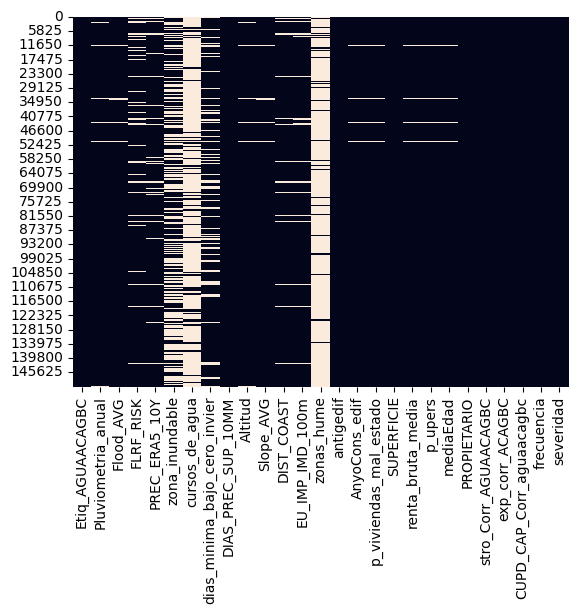

In [90]:
# Visualize ghosts cells (white = NaN).
import seaborn as sns
sns.heatmap(df.isna(), cbar=False)

In [91]:
# Elimino las columnas con mayor numero de celdas ghost:
df = df.drop(['zona_inundable', 'zonas_hume', 'cursos_de_agua'], axis=1)  # or axis='columns'

<Axes: >

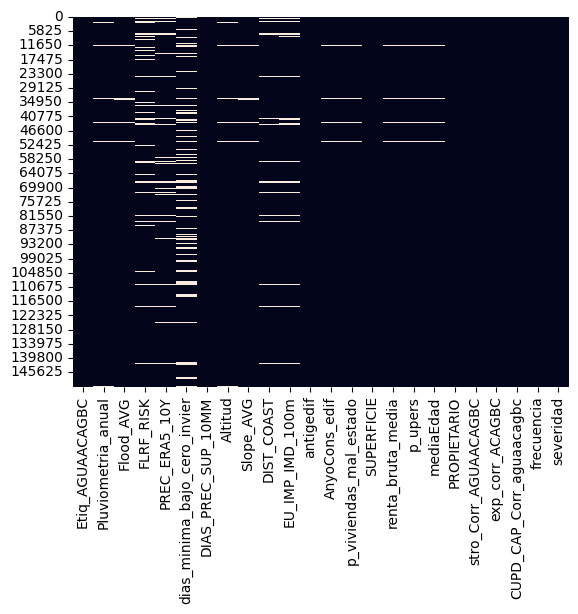

In [92]:
import seaborn as sns
sns.heatmap(df.isna(), cbar=False)  # Visualize ghosts (white = NaN).

A este conjunto de variables en las que aparecen algunos valores NaN (ghost) se le asignan el valor de la mediana en el caso de las variables numericas y la moda para las variables categóricas.

In [93]:
# 4.2 Imputar valores nulos
print("\nImputando valores nulos en variables numéricas con la mediana...")
#numeric_columns = ["Altitud", "FLRF_RISK", "Flood_AVG", "PREC_ERA5_10Y", "Pluviometria_anual", "renta_bruta_media"]
numeric_columns = ['Pluviometria_anual', 'Flood_AVG', 'FLRF_RISK', 'PREC_ERA5_10Y',
                   'dias_minima_bajo_cero_invier', 'DIAS_PREC_SUP_10MM', 'Altitud', 'Slope_AVG',
                   'DIST_COAST', 'EU_IMP_IMD_100m', 'antigedif', 'AnyoCons_edif', 'p_viviendas_mal_estado',
                   'SUPERFICIE', 'renta_bruta_media',  'p_upers', 'mediaEdad']
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].median())
print("✅ Imputación de valores nulos completada.")


Imputando valores nulos en variables numéricas con la mediana...
✅ Imputación de valores nulos completada.


<Axes: >

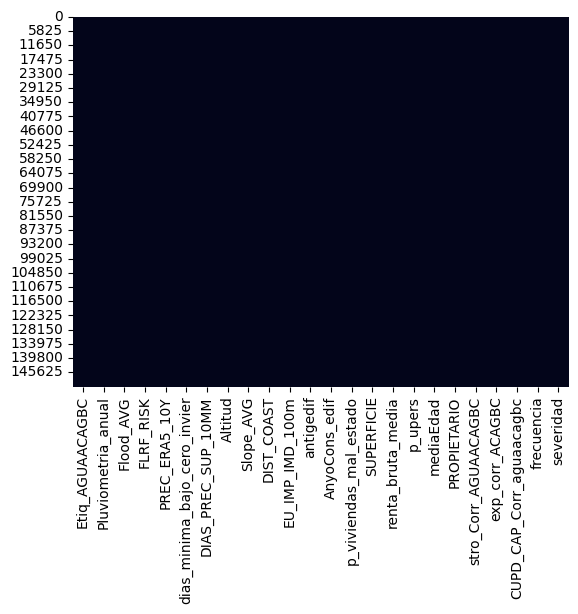

In [94]:
import seaborn as sns
sns.heatmap(df.isna(), cbar=False)  # Visualize ghosts (white = NaN).

In [95]:
# Creamos variables dummy para las columnas categóricas
key_words=['PROPIETARIO', 'Etiq_AGUAACAGBC']
#df_encoded = pd.get_dummies(df, columns=key_words, drop_first=True).astype(int)
df_encoded = pd.get_dummies(df, columns=key_words).astype(float)

In [96]:
cols_encoded = [each for each in df_encoded.columns if any(keyword in each for keyword in key_words)]
cols_encoded

['PROPIETARIO_N',
 'PROPIETARIO_S',
 'Etiq_AGUAACAGBC_Valores coherentes',
 'Etiq_AGUAACAGBC_Valores coherentes - 500.0']

In [97]:
df_encoded

,Pluviometria_anual,Flood_AVG,FLRF_RISK,PREC_ERA5_10Y,dias_minima_bajo_cero_invier,DIAS_PREC_SUP_10MM,Altitud,Slope_AVG,DIST_COAST,EU_IMP_IMD_100m,...,mediaEdad,stro_Corr_AGUAACAGBC,exp_corr_ACAGBC,CUPD_CAP_Corr_aguaacagbc,frecuencia,severidad,PROPIETARIO_N,PROPIETARIO_S,Etiq_AGUAACAGBC_Valores coherentes,Etiq_AGUAACAGBC_Valores coherentes - 500.0
0,336.0,0.329878,0.0,48.008861,5.25,12.0,552.0,10.040470,-101.0,88.0,...,41.971583,1.0,0.836066,766.60,1.196078,766.60,0.0,1.0,1.0,0.0
1,336.0,0.329878,0.0,48.008861,5.25,12.0,552.0,10.040470,-101.0,88.0,...,41.971583,1.0,0.273973,553.53,3.650000,553.53,0.0,1.0,1.0,0.0
2,336.0,0.329878,0.0,48.008861,5.25,12.0,552.0,10.040470,-101.0,84.0,...,41.971583,1.0,0.252055,841.33,3.967391,841.33,0.0,1.0,1.0,0.0
3,336.0,0.329878,0.0,48.008861,5.25,12.0,552.0,10.040470,-102.0,66.0,...,41.971583,1.0,0.915068,195.51,1.092814,195.51,0.0,1.0,1.0,0.0
4,336.0,0.329878,0.0,48.008861,5.25,12.0,552.0,10.040470,-102.0,68.0,...,41.971583,1.0,0.049315,351.09,20.277778,351.09,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151442,479.0,0.000000,0.0,50.212594,9.00,15.0,339.0,3.805965,-1.0,89.0,...,34.741143,1.0,0.336986,78.88,2.967480,78.88,0.0,1.0,1.0,0.0
151443,479.0,0.000000,0.0,50.212594,9.00,15.0,339.0,3.805965,-1.0,79.0,...,34.741143,1.0,0.589041,188.99,1.697674,188.99,0.0,1.0,1.0,0.0
151444,479.0,0.000000,0.0,50.212594,9.00,15.0,339.0,3.805965,0.0,81.0,...,34.741143,1.0,0.504110,631.33,1.983696,631.33,0.0,1.0,1.0,0.0
151445,479.0,0.000000,0.0,50.212594,9.00,15.0,339.0,3.805965,0.0,84.0,...,34.741143,1.0,0.580822,51.98,1.721698,51.98,0.0,1.0,1.0,0.0


In [98]:
Factores = [var for var in Factores if var not in key_words]
Factores

['Pluviometria_anual',
 'Flood_AVG',
 'FLRF_RISK',
 'PREC_ERA5_10Y',
 'zona_inundable',
 'cursos_de_agua',
 'dias_minima_bajo_cero_invier',
 'DIAS_PREC_SUP_10MM',
 'Altitud',
 'Slope_AVG',
 'DIST_COAST',
 'EU_IMP_IMD_100m',
 'zonas_hume',
 'antigedif',
 'AnyoCons_edif',
 'p_viviendas_mal_estado',
 'SUPERFICIE',
 'renta_bruta_media',
 'p_upers',
 'mediaEdad']

In [99]:
generar_resumen_exploratorio(df_encoded, list(df_encoded.columns))

,Variable,Tipo,Nulos,Cantidad,Promedio,Moda,Min,Max,Outliers (IQR),% Outliers
6,Altitud,Numérico,0,151447,412.190000,659.000000,4.000000,2326.000000,271,0.18%
11,AnyoCons_edif,Numérico,0,151447,1969.140000,1970.000000,1904.000000,2006.000000,8189,5.41%
19,CUPD_CAP_Corr_aguaacagbc,Numérico,0,151447,442.700000,51.360000,0.010000,2500.000000,13437,8.87%
5,DIAS_PREC_SUP_10MM,Numérico,0,151447,21.380000,17.000000,0.000000,89.200000,19426,12.83% ⚠️
8,DIST_COAST,Numérico,0,151447,-123.990000,-2.000000,-359.000000,2.000000,0,0.0%
9,EU_IMP_IMD_100m,Numérico,0,151447,76.750000,82.000000,0.000000,100.000000,4349,2.87%
24,Etiq_AGUAACAGBC_Valores coherentes,Numérico,0,151447,0.980000,1.000000,0.000000,1.000000,2300,1.52%
25,Etiq_AGUAACAGBC_Valores coherentes - 500.0,Numérico,0,151447,0.020000,0.000000,0.000000,1.000000,2300,1.52%
2,FLRF_RISK,Numérico,0,151447,0.590000,0.000000,0.000000,9.000000,19889,13.13% ⚠️
1,Flood_AVG,Numérico,0,151447,1.130000,0.000000,0.000000,8.740000,8984,5.93%


In [100]:
print("\nImputando valores nulos en variables categóricas con la moda...")
categorical_columns = ["Etiq_AGUAACAGBC_Valores coherentes - 500.0", "Etiq_AGUAACAGBC_Valores coherentes", 'PROPIETARIO_N', 'PROPIETARIO_S']
for col in categorical_columns:
    df_encoded[col] = df_encoded[col].fillna(df_encoded[col].mode()[0])
print("✅ Imputación de valores nulos en categóricas completada.")


Imputando valores nulos en variables categóricas con la moda...
✅ Imputación de valores nulos en categóricas completada.


In [101]:
# Ajustar outliers mediante winsorización
print("\nAjustando outliers mediante winsorización...")
df = ajustar_outliers_winsorizacion(df, numeric_columns, percentil_bajo=0.01, percentil_alto=0.99)
print("✅ Outliers ajustados.")


Ajustando outliers mediante winsorización...
✅ Outliers ajustados.


In [102]:
# Generar resumen exploratorio
removidos = ['zonas_hume', 'zona_inundable', 'cursos_de_agua']
#Factores = cols_encoded+Factores
Factores = [ variable for variable in Factores if variable not in removidos]
Factores
generar_resumen_exploratorio(df_encoded, Factores)

,Variable,Tipo,Nulos,Cantidad,Promedio,Moda,Min,Max,Outliers (IQR),% Outliers
6,Altitud,Numérico,0,151447,412.190000,659.000000,4.000000,2326.000000,271,0.18%
11,AnyoCons_edif,Numérico,0,151447,1969.140000,1970.000000,1904.000000,2006.000000,8189,5.41%
5,DIAS_PREC_SUP_10MM,Numérico,0,151447,21.380000,17.000000,0.000000,89.200000,19426,12.83% ⚠️
8,DIST_COAST,Numérico,0,151447,-123.990000,-2.000000,-359.000000,2.000000,0,0.0%
9,EU_IMP_IMD_100m,Numérico,0,151447,76.750000,82.000000,0.000000,100.000000,4349,2.87%
2,FLRF_RISK,Numérico,0,151447,0.590000,0.000000,0.000000,9.000000,19889,13.13% ⚠️
1,Flood_AVG,Numérico,0,151447,1.130000,0.000000,0.000000,8.740000,8984,5.93%
3,PREC_ERA5_10Y,Numérico,0,151447,53.740000,51.863943,31.180000,102.340000,301,0.2%
0,Pluviometria_anual,Numérico,0,151447,574.300000,469.000000,156.000000,2181.000000,20372,13.45% ⚠️
13,SUPERFICIE,Numérico,0,151447,4705.350000,1000.000000,0.000000,2330100.000000,15745,10.4% ⚠️


In [103]:
df["exp_corr_ACAGBC"].replace(0, np.nan, inplace=True)  # Evita divisiones por cero
df.dropna(subset=["exp_corr_ACAGBC"], inplace=True)  # Elimina filas con valores nulos después del reemplazo

In [104]:
missing_summary = df_encoded[Factores].isnull().sum()
print("Cantidad de valores nulos por factor:")
print(missing_summary[missing_summary > 0].sort_values(ascending=False))

resumen_valores_nulos(df_encoded, Factores)

Cantidad de valores nulos por factor:
Series([], dtype: int64)


,Valores Nulos,Porcentaje (%)


In [105]:
df_encoded.columns

Index(['Pluviometria_anual', 'Flood_AVG', 'FLRF_RISK', 'PREC_ERA5_10Y',
       'dias_minima_bajo_cero_invier', 'DIAS_PREC_SUP_10MM', 'Altitud',
       'Slope_AVG', 'DIST_COAST', 'EU_IMP_IMD_100m', 'antigedif',
       'AnyoCons_edif', 'p_viviendas_mal_estado', 'SUPERFICIE',
       'renta_bruta_media', 'p_upers', 'mediaEdad', 'stro_Corr_AGUAACAGBC',
       'exp_corr_ACAGBC', 'CUPD_CAP_Corr_aguaacagbc', 'frecuencia',
       'severidad', 'PROPIETARIO_N', 'PROPIETARIO_S',
       'Etiq_AGUAACAGBC_Valores coherentes',
       'Etiq_AGUAACAGBC_Valores coherentes - 500.0'],
      dtype='object')

In [106]:
Factores

['Pluviometria_anual',
 'Flood_AVG',
 'FLRF_RISK',
 'PREC_ERA5_10Y',
 'dias_minima_bajo_cero_invier',
 'DIAS_PREC_SUP_10MM',
 'Altitud',
 'Slope_AVG',
 'DIST_COAST',
 'EU_IMP_IMD_100m',
 'antigedif',
 'AnyoCons_edif',
 'p_viviendas_mal_estado',
 'SUPERFICIE',
 'renta_bruta_media',
 'p_upers',
 'mediaEdad']


🔍 **Top factores correlacionados con FRECUENCIA:** ['SUPERFICIE', 'EU_IMP_IMD_100m', 'antigedif', 'AnyoCons_edif', 'DIST_COAST']
🔍 **Top factores correlacionados con SEVERIDAD:** ['Pluviometria_anual', 'DIAS_PREC_SUP_10MM', 'mediaEdad', 'AnyoCons_edif', 'renta_bruta_media']


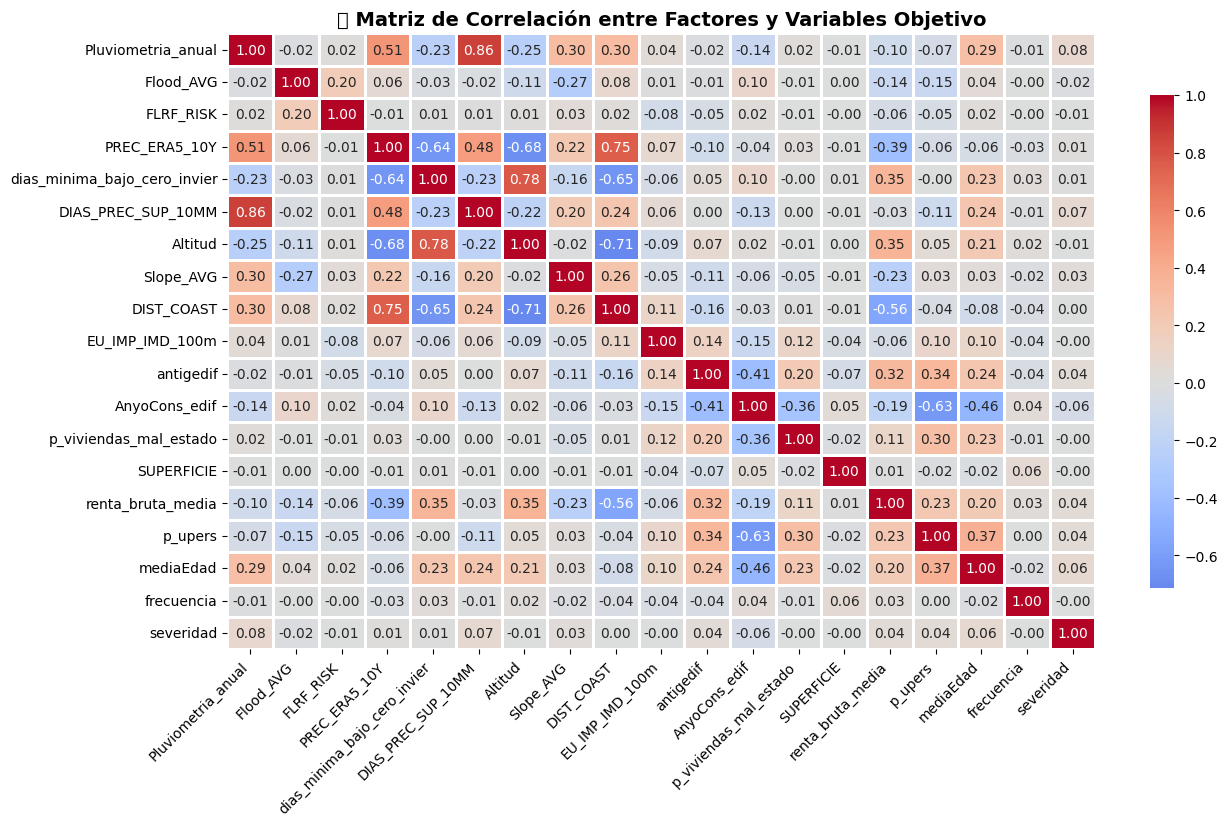

In [107]:
top_frecuencia, top_severidad = analizar_correlacion(df_encoded, Factores, cmap="coolwarm")

In [108]:
removed = ['Etiq_AGUAACAGBC_Valores coherentes','Etiq_AGUAACAGBC_Valores coherentes - 500.0']
Factores = [ var for var in Factores if var not in removed ]

In [109]:
Factores

['Pluviometria_anual',
 'Flood_AVG',
 'FLRF_RISK',
 'PREC_ERA5_10Y',
 'dias_minima_bajo_cero_invier',
 'DIAS_PREC_SUP_10MM',
 'Altitud',
 'Slope_AVG',
 'DIST_COAST',
 'EU_IMP_IMD_100m',
 'antigedif',
 'AnyoCons_edif',
 'p_viviendas_mal_estado',
 'SUPERFICIE',
 'renta_bruta_media',
 'p_upers',
 'mediaEdad']

In [110]:
df_encoded.columns

Index(['Pluviometria_anual', 'Flood_AVG', 'FLRF_RISK', 'PREC_ERA5_10Y',
       'dias_minima_bajo_cero_invier', 'DIAS_PREC_SUP_10MM', 'Altitud',
       'Slope_AVG', 'DIST_COAST', 'EU_IMP_IMD_100m', 'antigedif',
       'AnyoCons_edif', 'p_viviendas_mal_estado', 'SUPERFICIE',
       'renta_bruta_media', 'p_upers', 'mediaEdad', 'stro_Corr_AGUAACAGBC',
       'exp_corr_ACAGBC', 'CUPD_CAP_Corr_aguaacagbc', 'frecuencia',
       'severidad', 'PROPIETARIO_N', 'PROPIETARIO_S',
       'Etiq_AGUAACAGBC_Valores coherentes',
       'Etiq_AGUAACAGBC_Valores coherentes - 500.0'],
      dtype='object')

In [111]:
import patsy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
factores_freq_1 = ['SUPERFICIE', 'EU_IMP_IMD_100m', 'antigedif', 'AnyoCons_edif', 'DIST_COAST']
factores_freq_2 = Factores  # modelo completo

# Modelo 1: solo SUPERFICIE
formula_freq_1 = "frecuencia ~ " + " + ".join(factores_freq_1)
yf1, Xf1 = patsy.dmatrices(formula_freq_1, data=df_encoded, return_type='dataframe')
result_f1 = sm.GLM(yf1, Xf1, family=sm.families.Poisson()).fit()
df_f1 = yf1.copy()
df_f1["pred"] = result_f1.predict(Xf1)

#Modelo 2: completo
factores_formula = " + ".join([f"C({f})" if df_encoded[f].dtype == "object" else f for f in factores_freq_2])
formula_freq_2 = f"frecuencia ~ {factores_formula}"
yf2, Xf2 = patsy.dmatrices(formula_freq_2, data=df_encoded, return_type='dataframe')
result_f2 = sm.GLM(yf2, Xf2, family=sm.families.Poisson()).fit()
df_f2 = yf2.copy()
df_f2["pred"] = result_f2.predict(Xf2)

# Modelo 3 reducido de FRECUENCIA
formula_freq_reducido = "frecuencia ~ " + " + ".join(top_frecuencia)
yfr, Xfr = patsy.dmatrices(formula_freq_reducido, data=df_encoded, return_type='dataframe')
result_frecuencia_red = sm.GLM(yfr, Xfr, family=sm.families.Poisson()).fit()
df_fr_eval = yfr.copy()
df_fr_eval["pred"] = result_frecuencia_red.predict(Xfr)


📊 Frecuencia - Modelo 1 (SUPERFICIE)
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.9716e+06
Date:                Sun, 13 Apr 2025   Deviance:                   1.1386e+07
Time:                        15:22:56   Pearson chi2:                 2.89e+07
No. Iterations:                    13   Pseudo R-squ. (CS):             0.6660
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Inte

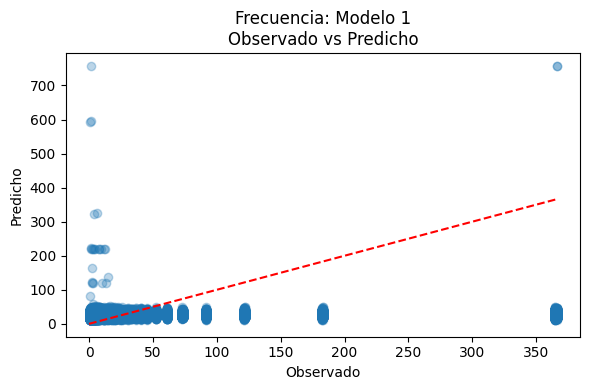

In [112]:
# Métricas y gráficos
print("\n📊 Frecuencia - Modelo 1 (SUPERFICIE)")
print(result_f1.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_f1["frecuencia"], df_f1["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_f1["frecuencia"], df_f1["pred"], alpha=0.3)
plt.plot([0, df_f1["frecuencia"].max()], [0, df_f1["frecuencia"].max()], 'r--')
plt.title("Frecuencia: Modelo 1\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()


📊 Frecuencia - Modelo 2 (Completo)
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151429
Model Family:                 Poisson   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.9451e+06
Date:                Sun, 13 Apr 2025   Deviance:                   1.1333e+07
Time:                        15:22:57   Pearson chi2:                 2.87e+07
No. Iterations:                    13   Pseudo R-squ. (CS):             0.7648
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

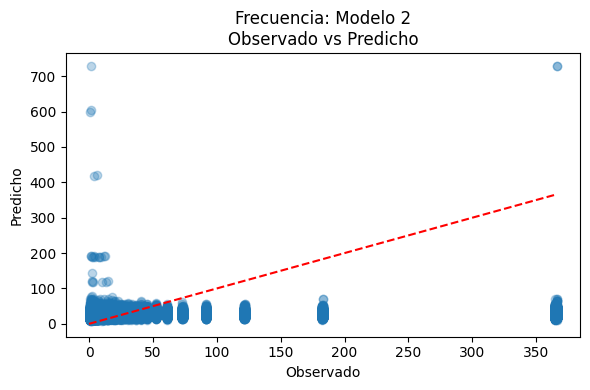

In [113]:
print("\n📊 Frecuencia - Modelo 2 (Completo)")
print(result_f2.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_f2["frecuencia"], df_f2["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_f2["frecuencia"], df_f2["pred"], alpha=0.3)
plt.plot([0, df_f2["frecuencia"].max()], [0, df_f2["frecuencia"].max()], 'r--')
plt.title("Frecuencia: Modelo 2\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()


📊 Frecuencia - Modelo 3 (Frecuencia)
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.9716e+06
Date:                Sun, 13 Apr 2025   Deviance:                   1.1386e+07
Time:                        15:22:58   Pearson chi2:                 2.89e+07
No. Iterations:                    13   Pseudo R-squ. (CS):             0.6660
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Inte

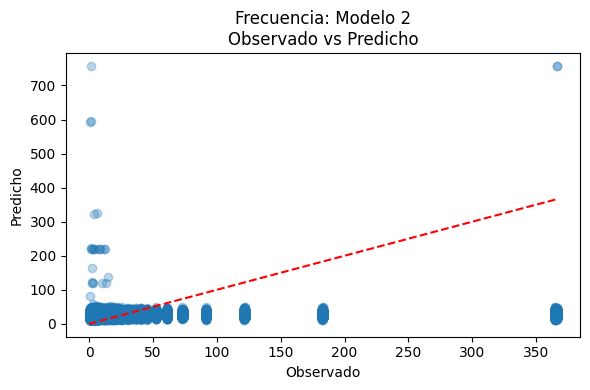

In [114]:
print("\n📊 Frecuencia - Modelo 3 (Frecuencia)")
print(result_frecuencia_red.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_fr_eval["frecuencia"], df_fr_eval["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_fr_eval["frecuencia"], df_fr_eval["pred"], alpha=0.3)
plt.plot([0, df_fr_eval["frecuencia"].max()], [0, df_fr_eval["frecuencia"].max()], 'r--')
plt.title("Frecuencia: Modelo 2\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

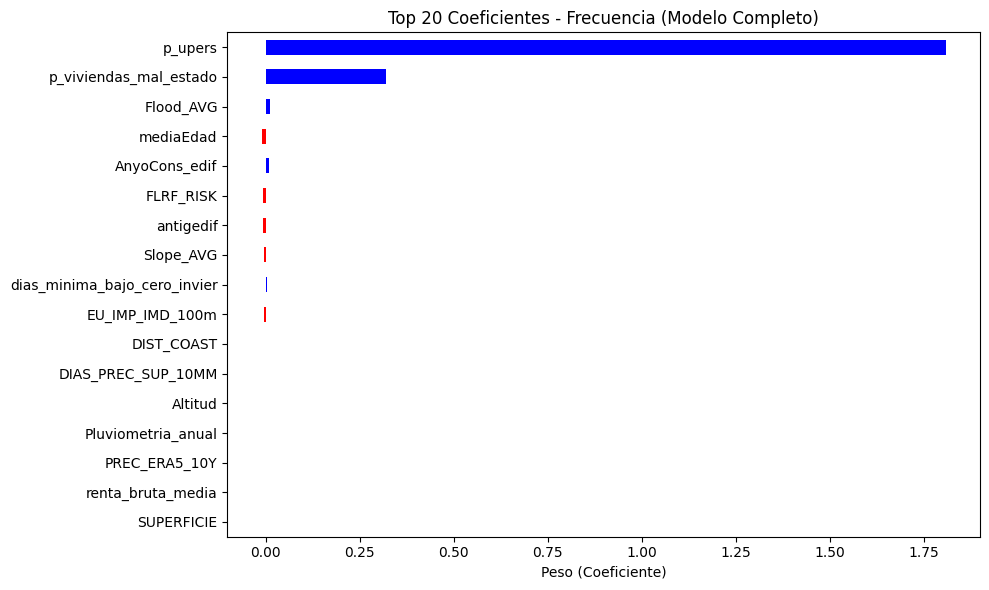

In [115]:
# Importancia de variables - Frecuencia (sin intercepto)
coef_freq = result_f2.params.drop("Intercept").sort_values(key=abs, ascending=False)
colors = ["blue" if c > 0 else "red" for c in coef_freq.head(20)]
plt.figure(figsize=(10, 6))
coef_freq.head(20).plot(kind='barh', color=colors)
plt.title("Top 20 Coeficientes - Frecuencia (Modelo Completo)")
plt.xlabel("Peso (Coeficiente)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [116]:
# -----------------------------
# Parte 2: SEVERIDAD - Evaluar dos modelos
# -----------------------------
df_sev = df_encoded[df_encoded["severidad"] > 0].copy()
factores_sev_1 = ['Pluviometria_anual', 'DIAS_PREC_SUP_10MM', 'mediaEdad', 'AnyoCons_edif', 'renta_bruta_media']
factores_sev_2 = Factores  # modelo completo

# Modelo 1: solo antigüedad
formula_sev_1 = "severidad ~ " + " + ".join(factores_sev_1)
ys1, Xs1 = patsy.dmatrices(formula_sev_1, data=df_sev, return_type='dataframe')
result_s1 = sm.GLM(ys1, Xs1, family=sm.families.Gamma(sm.families.links.log())).fit()
df_s1 = ys1.copy()
df_s1["pred"] = result_s1.predict(Xs1)

# Modelo 2: completo
factores_formula_sev = " + ".join([f"C({f})" if df_sev[f].dtype == "object" else f for f in factores_sev_2])
formula_sev_2 = f"severidad ~ {factores_formula_sev}"
ys2, Xs2 = patsy.dmatrices(formula_sev_2, data=df_sev, return_type='dataframe')
result_s2 = sm.GLM(ys2, Xs2, family=sm.families.Gamma(sm.families.links.log())).fit()
df_s2 = ys2.copy()
df_s2["pred"] = result_s2.predict(Xs2)

# Modelo 3 reducido a los factores significativos
formula_sev_reducido = "severidad ~ " + " + ".join(top_severidad)
df_sev_red = df[df["severidad"] > 0].copy()
ysr, Xsr = patsy.dmatrices(formula_sev_reducido, data=df_sev_red, return_type='dataframe')
result_severidad_red = sm.GLM(ysr, Xsr, family=sm.families.Gamma(sm.families.links.log())).fit()
df_sr_eval = ysr.copy()
df_sr_eval["pred"] = result_severidad_red.predict(Xsr)


📊 Severidad - Modelo 1 (Antigüedad)
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                          1.6442
Method:                          IRLS   Log-Likelihood:            -1.0755e+06
Date:                Sun, 13 Apr 2025   Deviance:                   2.1597e+05
Time:                        15:23:05   Pearson chi2:                 2.49e+05
No. Iterations:                    12   Pseudo R-squ. (CS):            0.01051
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

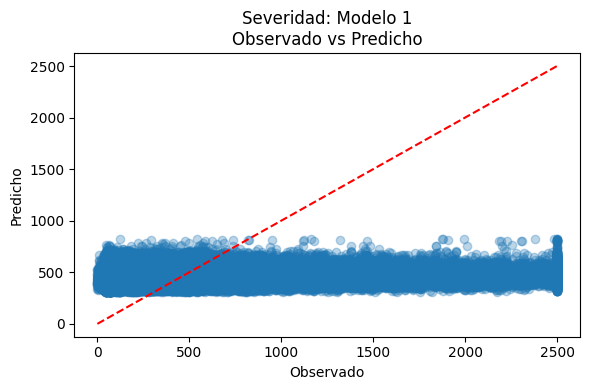

In [117]:
# Métricas y gráficos
print("\n📊 Severidad - Modelo 1 (Antigüedad)")
print(result_s1.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_s1["severidad"], df_s1["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_s1["severidad"], df_s1["pred"], alpha=0.3)
plt.plot([0, df_s1["severidad"].max()], [0, df_s1["severidad"].max()], 'r--')
plt.title("Severidad: Modelo 1\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()


📊 Severidad - Modelo 2 (Completo)
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151429
Model Family:                   Gamma   Df Model:                           17
Link Function:                    log   Scale:                          1.6399
Method:                          IRLS   Log-Likelihood:            -1.0752e+06
Date:                Sun, 13 Apr 2025   Deviance:                   2.1536e+05
Time:                        15:23:06   Pearson chi2:                 2.48e+05
No. Iterations:                    13   Pseudo R-squ. (CS):            0.01295
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

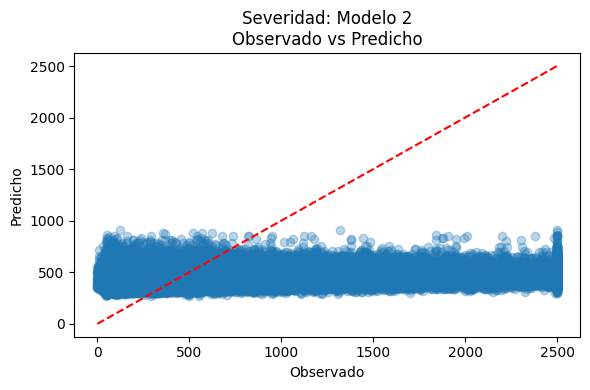

In [118]:
print("\n📊 Severidad - Modelo 2 (Completo)")
print(result_s2.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_s2["severidad"], df_s2["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_s2["severidad"], df_s2["pred"], alpha=0.3)
plt.plot([0, df_s2["severidad"].max()], [0, df_s2["severidad"].max()], 'r--')
plt.title("Severidad: Modelo 2\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

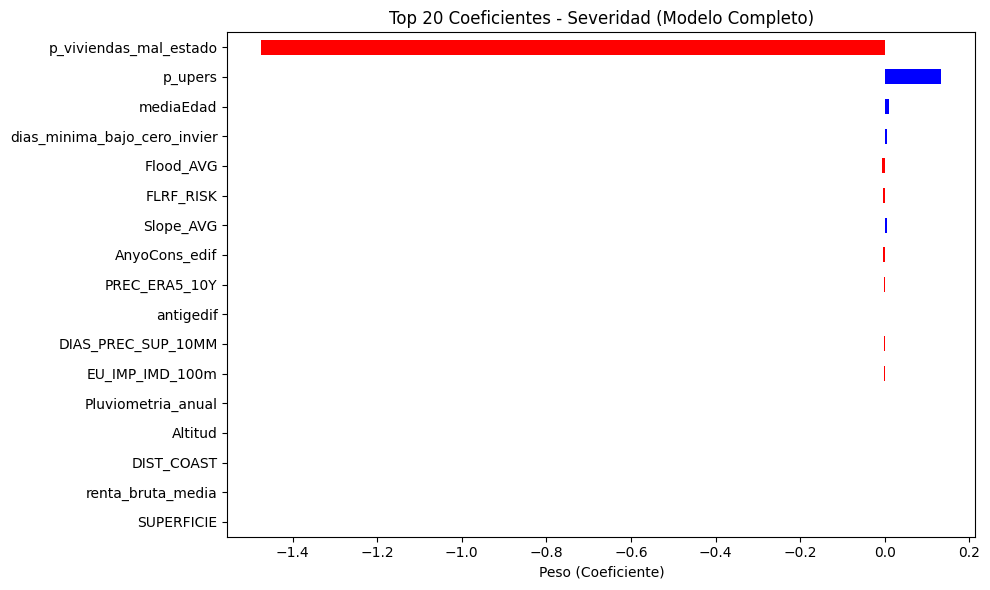

In [119]:
# Importancia de variables - Severidad (sin intercepto)
coef_sev = result_s2.params.drop("Intercept").sort_values(key=abs, ascending=False)
colors = ["blue" if c > 0 else "red" for c in coef_sev.head(20)]
plt.figure(figsize=(10, 6))
coef_sev.head(20).plot(kind='barh', color=colors)
plt.title("Top 20 Coeficientes - Severidad (Modelo Completo)")
plt.xlabel("Peso (Coeficiente)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

📊 Modelo Reducido - Severidad
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                          1.6438
Method:                          IRLS   Log-Likelihood:            -1.0755e+06
Date:                Sun, 13 Apr 2025   Deviance:                   2.1599e+05
Time:                        15:23:06   Pearson chi2:                 2.49e+05
No. Iterations:                    12   Pseudo R-squ. (CS):            0.01043
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

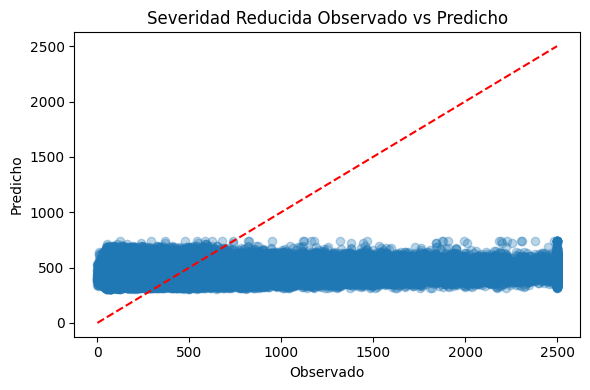

In [120]:
# Modelo reducido a los factores significativos

print("📊 Modelo Reducido - Severidad")
print(result_severidad_red.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_sr_eval["severidad"], df_sr_eval["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_sr_eval["severidad"], df_sr_eval["pred"], alpha=0.3)
plt.plot([0, df_sr_eval["severidad"].max()], [0, df_sr_eval["severidad"].max()], 'r--')
plt.title("Severidad Reducida Observado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

Pseudo R² Frecuencia - Completo: 0.0190
Pseudo R² Frecuencia - Reducido: 0.0144
Pseudo R² Severidad - Completo: 0.0148
Pseudo R² Severidad - Reducido: 0.0119


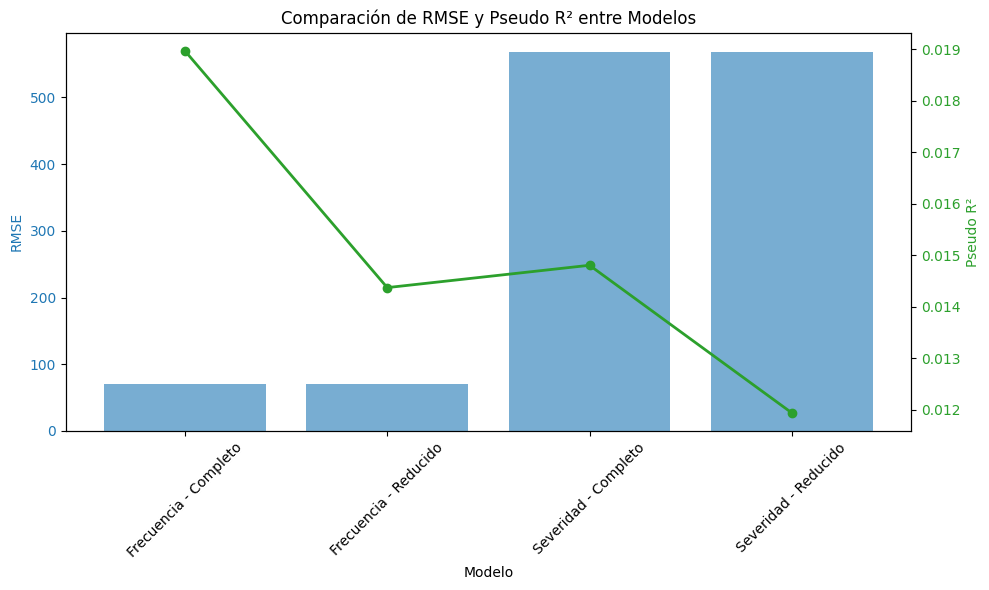

In [121]:
# -----------------------------
# Paso Extra: Cálculo de Pseudo R² para modelos GLM

# Pseudo R² para Frecuencia - Modelo Completo
null_model_f2 = sm.GLM(yf2, np.ones((yf2.shape[0], 1)), family=sm.families.Poisson()).fit()
pseudo_r2_f2 = 1 - result_f2.deviance / null_model_f2.deviance
print(f"Pseudo R² Frecuencia - Completo: {pseudo_r2_f2:.4f}")

# Pseudo R² para Frecuencia - Modelo Reducido
null_model_fr = sm.GLM(yfr, np.ones((yfr.shape[0], 1)), family=sm.families.Poisson()).fit()
pseudo_r2_fr = 1 - result_frecuencia_red.deviance / null_model_fr.deviance
print(f"Pseudo R² Frecuencia - Reducido: {pseudo_r2_fr:.4f}")

# Pseudo R² para Severidad - Modelo Completo
null_model_s2 = sm.GLM(ys2, np.ones((ys2.shape[0], 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2_s2 = 1 - result_s2.deviance / null_model_s2.deviance
print(f"Pseudo R² Severidad - Completo: {pseudo_r2_s2:.4f}")

# Pseudo R² para Severidad - Modelo Reducido
null_model_sr = sm.GLM(ysr, np.ones((ysr.shape[0], 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2_sr = 1 - result_severidad_red.deviance / null_model_sr.deviance
print(f"Pseudo R² Severidad - Reducido: {pseudo_r2_sr:.4f}")

# Gráfico comparativo de RMSE y Pseudo R²
# Calcular RMSE para los modelos antes de usarlos en metrics_df
rmse_frec_completo = np.sqrt(mean_squared_error(df_f2["frecuencia"], df_f2["pred"]))
rmse_frec_reducido = np.sqrt(mean_squared_error(df_fr_eval["frecuencia"], df_fr_eval["pred"]))
rmse_sev_completo = np.sqrt(mean_squared_error(df_s2["severidad"], df_s2["pred"]))
rmse_sev_reducido = np.sqrt(mean_squared_error(df_sr_eval["severidad"], df_sr_eval["pred"]))

# Gráfico comparativo de RMSE y Pseudo R²
metrics_df = pd.DataFrame({
    "Modelo": [
        "Frecuencia - Completo", "Frecuencia - Reducido",
        "Severidad - Completo", "Severidad - Reducido"
    ],
    "RMSE": [
        rmse_frec_completo, rmse_frec_reducido,
        rmse_sev_completo, rmse_sev_reducido
    ],
    "Pseudo R²": [
        pseudo_r2_f2, pseudo_r2_fr,
        pseudo_r2_s2, pseudo_r2_sr
    ]
})

# Graficar
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel("Modelo")
ax1.set_ylabel("RMSE", color=color)
ax1.bar(metrics_df["Modelo"], metrics_df["RMSE"], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Pseudo R²", color=color)
ax2.plot(metrics_df["Modelo"], metrics_df["Pseudo R²"], color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Comparación de RMSE y Pseudo R² entre Modelos")
plt.tight_layout()
plt.show()

In [122]:
formula = "severidad ~ Pluviometria_anual + DIAS_PREC_SUP_10MM + mediaEdad + AnyoCons_edif + renta_bruta_media"
model_nb = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial(), offset=np.log(df['exp_corr_ACAGBC'])).fit()
print(model_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2879e+06
Date:                Sun, 13 Apr 2025   Deviance:                   6.4467e+05
Time:                        15:23:10   Pearson chi2:                 3.44e+06
No. Iterations:                    13   Pseudo R-squ. (CS):            0.03269
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.0585      0